<a href="https://colab.research.google.com/github/FedericoSabbadini/DeepLearning/blob/main/homeworks/H9/H9_LSTM_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 9: LSTM Sentiment Analysis

*Exercise*: Build your own LSTM network and try to achieve the highest possible accuracy on Twitter Dataset (check the TODO items). See also the [LSTM_IMDB_Sentiment_Analysis](https://colab.research.google.com/github/serivan/DeepLearning/blob/master/10-AttentionMechanisms/pytorch/LSTM_IMDB_Sentiment_Analysis.ipynb) Notebook.

Moreover you can consider to use Grid search or Randomized search or Optuna in order to define the hyperparameters.

# **Twitter Sentiment Analysis**

*My ridiculous dog is amazing. [sentiment: positive]*

With all of the tweets circulating every second it is hard to tell whether the sentiment behind a specific tweet will impact a company, or a person's, brand for being viral (positive), or devastate profit because it strikes a negative tone. Capturing sentiment in language is important in these times where decisions and reactions are created and updated in seconds. But, which words actually lead to the sentiment description? In this competition you will need to pick out the part of the tweet (word or phrase) that reflects the sentiment.

Help build your skills in this important area with this broad dataset of tweets. Work on your technique to grab a top spot in this competition. What words in tweets support a positive, negative, or neutral sentiment? How can you help make that determination using machine learning tools?


Useful link:


*   [Dataset](https://www.kaggle.com/datasets/yasserh/twitter-tweets-sentiment-dataset)
*   [Competition](https://www.kaggle.com/competitions/tweet-sentiment-extraction/overview)



Import the dataset and install libraries

In [73]:
import torch

# if present, use the gpu as a device

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


In [74]:
%%capture

!pip install transformers
!wget https://raw.githubusercontent.com/serivan/DeepLearning/master/Datasets/Tweets.csv

# **Dataset preprocessing**

In [75]:
import pandas as pd

df = pd.read_csv('Tweets.csv')
df

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive


In [76]:
# Remove columns that we don't need.

df.drop(["textID", "selected_text"], axis=1, inplace=True)
df

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative
...,...,...
27476,wish we could come see u on Denver husband l...,negative
27477,I`ve wondered about rake to. The client has ...,negative
27478,Yay good for both of you. Enjoy the break - y...,positive
27479,But it was worth it ****.,positive


In [77]:
# Descriptive statistics
df.describe()

,text,sentiment
count,27480,27481
unique,27480,3
top,All this flirting going on - The ATG smiles...,neutral
freq,1,11118


In [78]:
# Remove missing and duplicates value

df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

df

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative
...,...,...
27476,wish we could come see u on Denver husband l...,negative
27477,I`ve wondered about rake to. The client has ...,negative
27478,Yay good for both of you. Enjoy the break - y...,positive
27479,But it was worth it ****.,positive


In [79]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [80]:
from nltk.corpus import stopwords

stop = stopwords.words('english')

In [81]:
mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot",
           "'cause": "because", "could've": "could have", "couldn't": "could not",
           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not",
           "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will",
           "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will",
           "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will",
           "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have",
           "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have",
           "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not",
           "might've": "might have","mightn't": "might not","mightn't've": "might not have",
           "must've": "must have", "mustn't": "must not", "mustn't've": "must not have",
           "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
           "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would",
           "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have",
           "she's": "she is", "should've": "should have", "shouldn't": "should not",
           "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is",
           "that'd": "that would", "that'd've": "that would have", "that's": "that is",
           "there'd": "there would", "there'd've": "there would have", "there's": "there is",
           "here's": "here is","they'd": "they would", "they'd've": "they would have",
           "they'll": "they will", "they'll've": "they will have", "they're": "they are",
           "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would",
           "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have",
           "we're": "we are", "we've": "we have", "weren't": "were not",
           "what'll": "what will", "what'll've": "what will have","what're": "what are",
           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have",
           "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will",
           "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is",
           "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have",
           "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have",
           "y'all're": "you all are","y'all've": "you all have","you'd": "you would",
           "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
           "you're": "you are", "you've": "you have" }

In [82]:
from bs4 import BeautifulSoup
import string
import re

# Function to clean data

def clean_text(text,lemmatize = True):
    soup = BeautifulSoup(text, "html.parser") # Remove html tags
    text = soup.get_text()

    # Expanding chatwords and contracts clearing contractions
    text = ' '.join([mapping[t] if t in mapping else t for t in text.split(" ")])
    emoji_clean= re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)

    text = emoji_clean.sub(r'',text)
    text = re.sub(r'\.(?=\S)', '. ',text)   # Add space after full stop
    text = re.sub(r'http\S+', '', text)     # Remove urls
    text = "".join([word.lower() for word in text if word not in string.punctuation]) # Remove punctuation

    # Return token
    return " ".join([word for word in text.split() if word not in stop and word.isalpha()])

In [83]:
df['text'] = df['text'].apply(clean_text)
df["sentiment"] = [2 if s == "positive" else 0 if s == "negative" else 1 for s in df.sentiment.tolist()]

df

,text,sentiment
0,id responded going,1
1,sooo sad miss san diego,0
2,boss bullying,0
3,interview leave alone,0
4,sons couldnt put releases already bought,0
...,...,...
27476,wish could come see u denver husband lost job ...,0
27477,ive wondered rake client made clear net dont f...,0
27478,yay good enjoy break probably need hectic week...,2
27479,worth,2


# **Data analysis**

/tmp/ipython-input-3344640268.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df.sentiment, palette=['red', 'brown', 'green'], order=[0, 1, 2])


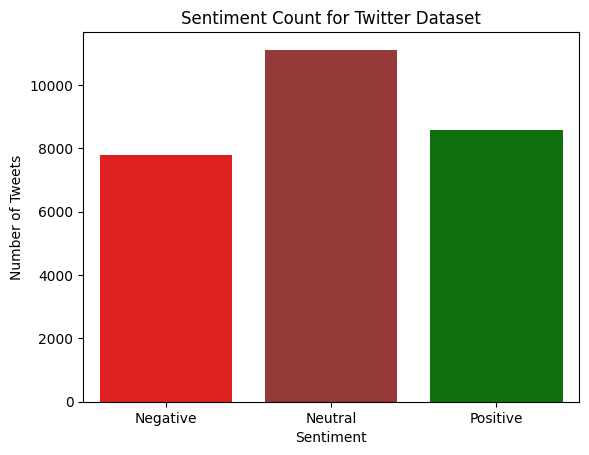

In [84]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x=df.sentiment, palette=['red', 'brown', 'green'], order=[0, 1, 2])

plt.xticks(ticks=np.arange(3), labels=['Negative', 'Neutral', 'Positive'])
plt.title('Sentiment Count for Twitter Dataset')
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')
plt.show()

In [85]:
print('Negative reviews are', (round(df['sentiment'].value_counts()[0])),' i.e.', round(df['sentiment'].value_counts()[0]/len(df)*100, 2), '% of the dataset')
print('Neutral  reviews are', (round(df['sentiment'].value_counts()[1])),'i.e.', round(df['sentiment'].value_counts()[1]/len(df)*100, 2), '% of the dataset')
print('Positive reviews are', (round(df['sentiment'].value_counts()[2])),' i.e.', round(df['sentiment'].value_counts()[2]/len(df)*100, 2), '% of the dataset')

Negative reviews are 7781  i.e. 28.32 % of the dataset
Neutral  reviews are 11117 i.e. 40.45 % of the dataset
Positive reviews are 8582  i.e. 31.23 % of the dataset


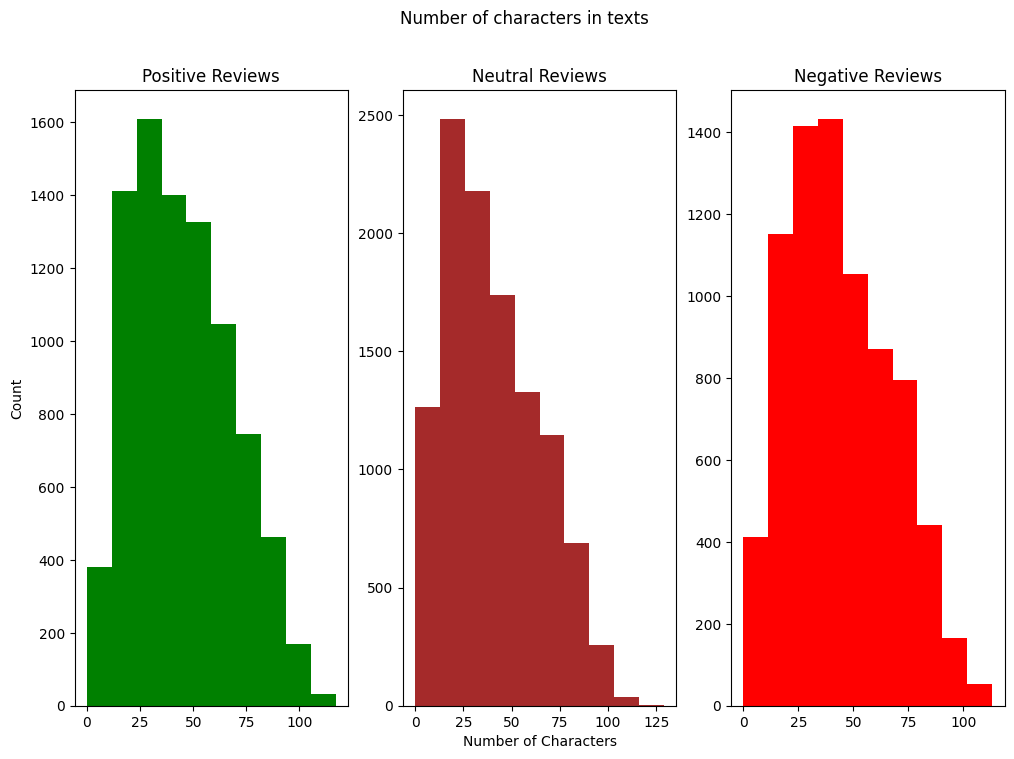

In [86]:
text_len_neg = df[df.sentiment == 0]['text'].str.len()
text_len_pos = df[df.sentiment == 2]['text'].str.len()
text_len_neu = df[df.sentiment == 1]['text'].str.len()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 8))
ax1.hist(text_len_pos, color='green')
ax1.set_title('Positive Reviews')
ax1.set_ylabel('Count')

ax2.hist(text_len_neu, color='brown')
ax2.set_title('Neutral Reviews')
ax2.set_xlabel('Number of Characters')

ax3.hist(text_len_neg, color='red')
ax3.set_title('Negative Reviews')
fig.suptitle('Number of characters in texts')
plt.show()

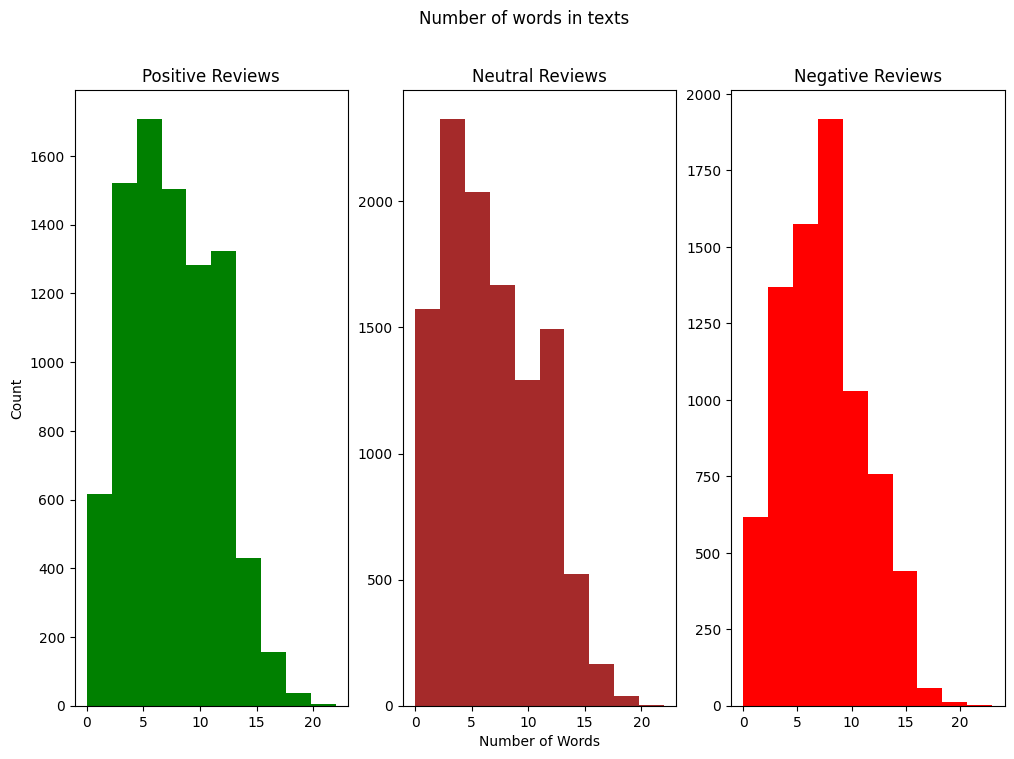

In [87]:
text_len_neg = df[df.sentiment == 0]['text'].str.split().map(lambda x: len(x))
text_len_neu = df[df.sentiment == 1]['text'].str.split().map(lambda x: len(x))
text_len_pos = df[df.sentiment == 2]['text'].str.split().map(lambda x: len(x))


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 8))
ax1.hist(text_len_pos, color='green')
ax1.set_title('Positive Reviews')
ax1.set_ylabel('Count')

ax2.hist(text_len_neu, color='brown')
ax2.set_title('Neutral Reviews')
ax2.set_xlabel('Number of Words')

ax3.hist(text_len_neg, color='red')
ax3.set_title('Negative Reviews')
fig.suptitle('Number of words in texts')
plt.show()

# Train & Test split

In [88]:
from sklearn.model_selection import train_test_split

# Splitting into train and test

SEED = 11
test_size = 0.2

train, test = train_test_split(df, test_size=test_size, random_state=SEED)
test, val = train_test_split(test, test_size=0.5, random_state=SEED)



# **Predictive Modelling using GRU**

In [89]:
from torch.utils.data import Dataset
import torch

def prepare_sequence(rev, vocab, maxlen):
    idxs = [vocab[w] if w in vocab else vocab["UNK"] for w in rev.split()]
    idxs = [idxs[i] if i < len(idxs) else vocab["PAD"] for i in range(maxlen)]

    return torch.tensor(idxs, dtype=torch.long)


class FilmReviewDataset(Dataset):

    def __init__(self, df, vocab, maxlen):
        super(FilmReviewDataset, self).__init__()

        self.text = df.text.apply(prepare_sequence, args=(vocab, maxlen)).tolist()
        self.sentiment = df.sentiment.tolist()


    def __getitem__(self, index):
        rev = self.text[index]
        sent = self.sentiment[index]

        return rev, sent

    def __len__(self):
        return len(self.text)

    def get_sentiment(self):
        return self.sentiment


In [90]:
# Defining Vocabulary
from collections import Counter

maxlen = 0
vocab = {"PAD": 0, "UNK": 1}

maxlen = max(df['text'].apply(lambda x: len(x.split())))
word_counts = Counter()
for text in df['text']:
    for word in text.split():
        word_counts[word] += 1

vocab = {"PAD": 0, "UNK": 1}
for i, word in enumerate(word_counts.keys(), start=2):
    vocab[word] = i


print(maxlen, len(vocab))

trainset = FilmReviewDataset(train, vocab, maxlen)
valset = FilmReviewDataset(val, vocab,maxlen)
testset = FilmReviewDataset(test, vocab, maxlen)

23 24850


Documentation used to build this model:


1.   [nn](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html)
2.   [nn.GRU](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html) check *num_layers*, *dropout*, *bidirectional* parameters
3.   [nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html?highlight=linear#torch.nn.Linear)

\# **TODO**: Build a GRU model for multi-classification task



1.   Embedding
2.   GRU
5.   Classifier


Choose an appropriate **loss function** and find and appropriate way to select the most probable class.



In [91]:
from tqdm import tqdm
from torch import nn
import torch
import copy

class FilmModel(nn.Module):
    def __init__(self, maxlen, vocab_size, embedding_dim, hidden_dim, num_classes=3):
        super(FilmModel, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.gru = nn.GRU(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=1,
            dropout=0.2,
            bidirectional=True,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_dim * 2, num_classes)  # bidirectional = 2x hidden_dim
        self.dropout = nn.Dropout(0.3)

    def forward(self, idxs):
        x = self.embedding(idxs)
        out, _ = self.gru(x)
        out = self.dropout(out[:, -1, :])  # take last hidden state
        logits = self.fc(out)
        return logits




    def train_classifier(self, trainloader, valloader, epochs, criterion, optimizer, device):
        train_losses = []
        train_accs = []
        val_losses = []
        val_accs = []

        best_epoch = 0
        best_loss = np.inf

        for ep in range(epochs):
            self.train()
            running_loss = 0.0
            acc = 0
            total = 0

            for it, (revs, labels) in enumerate(tqdm(trainloader)):

                revs = revs.to(device)
                labels = labels.to(device)

                # Forward pass
                logits = self.forward(revs)
                loss = criterion(logits, labels)
                running_loss += loss.item()

                # Backpropagation
                loss.backward()
                optimizer.step()

                optimizer.zero_grad()

                # TODO: compute the class predictions
                predictions = torch.argmax(logits, dim=1)
                acc += (predictions.detach().cpu().numpy() == labels.detach().cpu().numpy()).sum()


                total += len(labels)

            train_loss = running_loss/len(trainloader)
            train_losses.append(train_loss)

            epoch_acc = acc*100/total
            train_accs.append(epoch_acc)

            # Validation
            val_loss, val_acc = self.validation(valloader, criterion, device)

            val_losses.append(val_loss)
            val_accs.append(val_acc)

            print(f"\nEpoch {ep+1}")
            if val_loss < best_loss:
                print(f"\tBest validation loss improved from {round(best_loss, 3)} to {round(val_loss, 3)}\n")
                torch.save(self.state_dict(), "tuned_models.pt")

                best_loss = val_loss
                best_epoch = ep + 1

            print(f"\tTrain Loss {round(train_loss, 3)} - Train Accuracy {round(epoch_acc, 2)}%")
            print(f"\tValid Loss {round(val_loss, 3)} - Valid Accuracy {round(val_acc, 2)}%\n")

        print(f"Best model at epoch {best_epoch} saved in tuned_models.pt")
        return train_losses, val_losses, train_accs, val_accs


    def validation(self, dataloader, criterion, device):
        self.eval()

        running_loss = 0
        acc = 0
        total = 0

        for it, (revs, labels) in enumerate(tqdm(dataloader)):

            with torch.no_grad():
                revs = revs.to(device)
                labels = labels.to(device)

                logits = self.forward(revs)

                loss = criterion(logits.squeeze(-1), labels) # Removed .float()
                running_loss += loss.item()

                # TODO: compute the class predictions

                predictions = torch.argmax(logits, dim=1)
                acc += (predictions.detach().cpu().numpy() == labels.detach().cpu().numpy()).sum()

                total += len(labels)

        val_loss = running_loss/len(dataloader)
        val_acc = acc*100/total

        return val_loss, val_acc


    def predict(self, dataloader, device):
        self.eval()

        predictions = []
        for it, (revs, labels) in enumerate(tqdm(dataloader)):

            with torch.no_grad():
                revs = revs.to(device)

                logits = self.forward(revs)

                # TODO: compute the class predictions
                preds = torch.argmax(logits, dim=1)
                predictions.append(preds.detach().cpu().numpy())


        return predictions

In [92]:
from google.colab import auth
auth.authenticate_user()

In [93]:
import pandas as pd

# https://cloud.google.com/resource-manager/docs/creating-managing-projects
project_id = 'rapid-bricolage-477719-d0'
sample_count = 2000

row_count = pd.io.gbq.read_gbq('''
  SELECT
    COUNT(*) as total
  FROM `bigquery-public-data.samples.gsod`
''', project_id=project_id).total[0]

df = pd.io.gbq.read_gbq(f'''
  SELECT
    *
  FROM
    `bigquery-public-data.samples.gsod`
  WHERE RAND() < {sample_count}/{row_count}
''', project_id=project_id)

print(f'Full dataset has {row_count} rows')

/tmp/ipython-input-3060402324.py:7: FutureWarning: read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq
  row_count = pd.io.gbq.read_gbq('''
/tmp/ipython-input-3060402324.py:13: FutureWarning: read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq
  df = pd.io.gbq.read_gbq(f'''


Full dataset has 114420316 rows


In [94]:
df.describe()

,station_number,wban_number,year,month,day,mean_temp,num_mean_temp_samples,mean_dew_point,num_mean_dew_point_samples,mean_sealevel_pressure,...,mean_visibility,num_mean_visibility_samples,mean_wind_speed,num_mean_wind_speed_samples,max_sustained_wind_speed,max_gust_wind_speed,max_temperature,min_temperature,total_precipitation,snow_depth
count,1992.0,1992.0,1992.0,1992.0,1992.0,1992.000000,1992.0,1910.000000,1910.0,1521.000000,...,1806.000000,1806.0,1969.000000,1969.0,1932.000000,282.000000,1991.000000,0.0,1834.000000,105.000000
mean,506683.74247,90567.074799,1986.994478,6.569779,15.957831,52.922741,12.830321,42.016597,12.696335,1014.675213,...,12.556146,12.508306,6.686948,12.784662,12.073965,25.482979,44.182521,NaN,0.073822,10.996190
std,298258.93389,26047.862886,15.989747,3.406961,8.849953,23.829913,7.836112,22.383804,7.84234,9.706659,...,10.179830,7.781126,5.043777,7.820285,6.844397,10.301881,23.929541,NaN,0.399573,10.470865
min,10080.0,65.0,1934.0,1.0,1.0,-56.200001,4.0,-61.900002,4.0,951.500000,...,0.000000,4.0,0.000000,4.0,1.000000,8.000000,-61.599998,NaN,0.000000,0.400000
25%,247605.0,99999.0,1977.0,4.0,9.0,39.400002,7.0,29.900000,7.0,1009.200012,...,6.500000,6.0,3.300000,7.0,7.800000,19.000000,32.000000,NaN,0.000000,3.100000
50%,543250.0,99999.0,1989.0,7.0,16.0,55.799999,8.0,44.150000,8.0,1014.599976,...,9.900000,8.0,5.600000,8.0,11.100000,23.599999,46.799999,NaN,0.000000,7.900000
75%,725044.0,99999.0,2000.0,10.0,24.0,71.199997,23.0,57.299999,23.0,1020.099976,...,15.000000,23.0,8.700000,23.0,15.000000,29.900000,61.000000,NaN,0.010000,15.700000
max,999999.0,99999.0,2010.0,12.0,31.0,98.900002,24.0,81.099998,24.0,1058.800049,...,99.400002,24.0,56.700001,24.0,66.000000,77.699997,86.400002,NaN,13.540000,54.299999


\#TODO Set the hyperparameters manually or using **grid search**

In [95]:
EMB_DIM  =128
LSTM_DIM =128

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = FilmModel(maxlen, len(vocab), EMB_DIM, LSTM_DIM).to(device)

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


In [96]:
from torch import optim
import numpy as np

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

batch_size =64

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size)

epochs = 10
train_losses, val_losses, train_accs, val_accs = model.train_classifier(trainloader, valloader, epochs, criterion, optimizer, device)

100%|██████████| 43/43 [00:00<00:00, 484.39it/s]



Epoch 1
	Best validation loss improved from inf to 0.888

	Train Loss 1.015 - Train Accuracy 46.94%
	Valid Loss 0.888 - Valid Accuracy 57.9%



100%|██████████| 43/43 [00:00<00:00, 597.19it/s]



Epoch 2
	Best validation loss improved from 0.888 to 0.768

	Train Loss 0.783 - Train Accuracy 65.78%
	Valid Loss 0.768 - Valid Accuracy 66.7%



100%|██████████| 43/43 [00:00<00:00, 203.38it/s]



Epoch 3
	Best validation loss improved from 0.768 to 0.757

	Train Loss 0.647 - Train Accuracy 74.23%
	Valid Loss 0.757 - Valid Accuracy 67.58%



100%|██████████| 43/43 [00:00<00:00, 842.01it/s]



Epoch 4
	Train Loss 0.527 - Train Accuracy 80.32%
	Valid Loss 0.802 - Valid Accuracy 66.59%



100%|██████████| 43/43 [00:00<00:00, 894.07it/s]



Epoch 5
	Train Loss 0.412 - Train Accuracy 85.72%
	Valid Loss 0.884 - Valid Accuracy 65.72%



100%|██████████| 43/43 [00:00<00:00, 937.81it/s]



Epoch 6
	Train Loss 0.312 - Train Accuracy 90.05%
	Valid Loss 1.001 - Valid Accuracy 66.08%



100%|██████████| 43/43 [00:00<00:00, 899.52it/s]



Epoch 7
	Train Loss 0.23 - Train Accuracy 93.19%
	Valid Loss 1.106 - Valid Accuracy 65.79%



100%|██████████| 43/43 [00:00<00:00, 936.19it/s]



Epoch 8
	Train Loss 0.182 - Train Accuracy 94.7%
	Valid Loss 1.219 - Valid Accuracy 65.5%



100%|██████████| 43/43 [00:00<00:00, 878.91it/s]



Epoch 9
	Train Loss 0.149 - Train Accuracy 95.86%
	Valid Loss 1.309 - Valid Accuracy 65.72%



100%|██████████| 43/43 [00:00<00:00, 940.20it/s]


Epoch 10
	Train Loss 0.123 - Train Accuracy 96.45%
	Valid Loss 1.308 - Valid Accuracy 65.68%

Best model at epoch 3 saved in tuned_models.pt


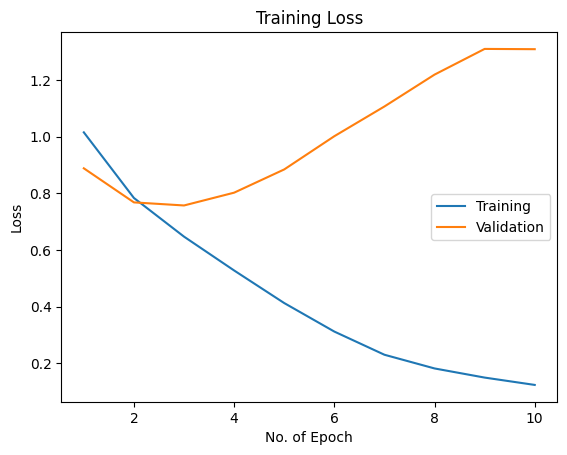

In [97]:
plt.plot(range(1, epochs+1), train_losses, label="Training")
plt.plot(range(1, epochs+1), val_losses, label="Validation")
plt.xlabel("No. of Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend(loc="center right")
plt.show()

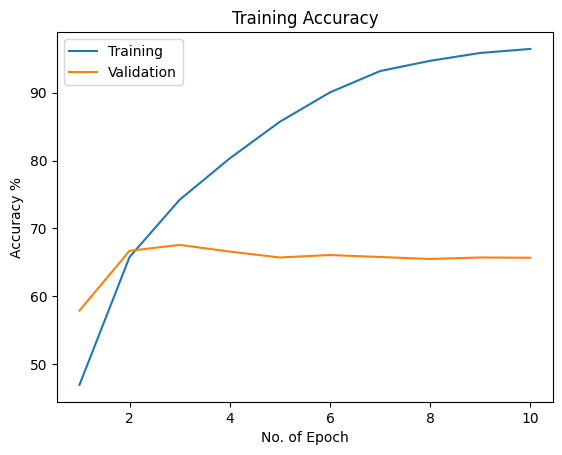

In [98]:
plt.plot(range(1, epochs+1), train_accs, label="Training")
plt.plot(range(1, epochs+1), val_accs, label="Validation")
plt.xlabel("No. of Epoch")
plt.ylabel("Accuracy %")
plt.title("Training Accuracy")
plt.legend(loc="upper left")
plt.show()

In [99]:
from sklearn.metrics import classification_report

model = FilmModel(maxlen, len(vocab), EMB_DIM, LSTM_DIM)
model.load_state_dict(torch.load("tuned_models.pt"))
model.to(device)

predictions = model.predict(testloader, device)
predictions = np.concatenate(predictions)

print(classification_report(testset.sentiment, predictions, target_names=["negative", "neutral", "positive"]))


100%|██████████| 43/43 [00:00<00:00, 1040.06it/s]

              precision    recall  f1-score   support

    negative       0.77      0.55      0.64       751
     neutral       0.63      0.79      0.70      1174
    positive       0.76      0.68      0.72       823

    accuracy                           0.69      2748
   macro avg       0.72      0.67      0.69      2748
weighted avg       0.71      0.69      0.69      2748

